# Getting Started with CellRank

## Preliminaries

CellRank is a software toolkit to study dynamical biological processes, like development, regeneration, cancer or reprogramming, based on multi-view single-cell genomics data {cite}`lange:22`, including RNA velocity {cite}`bergen:20,manno:18`, developmental potentials {cite}`gulati:20`, pseudotemporal orderings {cite}`setty:19, haghverdi:16, bendall:14,trapnell:14`, (spatial) time course studies {cite}`schiebinger:19,klein:23`, lineage-traced data {cite}`lange:23,forrow:21,raj:18,spanjaard:18,alemany:18`, metabolic labels {cite}`qiu:22, erhard:19, battich:20,qiu:20`, and more.  

Oftentimes, the type of downstream analysis does not depend on the modality that was used to estimate cellular transitions - that's why we modularized CellRank into {mod}`~cellrank.kernels`, which compute cell-cell transition matrices, and {mod}`~cellrank.estimators`, which analyze the transition matrices. 

In this tutorial, you will learn how to:

- use CellRank {mod}`~cellrank.kernels` to compute a transition matrix of cellular dynamics. 
- use CellRank {mod}`~cellrank.estimators` to analyze the transition matrix, including the computation of {meth}`fate probabilities <cellrank.estimators.GPCCA.compute_fate_probabilities>`, {meth}`driver genes <cellrank.estimators.GPCCA.compute_lineage_drivers>`, and {func}`gene expression trends <cellrank.pl.gene_trends>`. 
- read and write CellRank {mod}`~cellrank.kernels`.  

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/blob/main/tutorials/general/100_getting_started.ipynb).

:::{image} ../_static/img/100_cellrank_overview_dark_mode.png
:class: only-dark
:width: 800px
:::

:::{figure-md} fig-structure

<img src="../_static/img/100_cellrank_overview.png" alt="CellRank is a versatile toolking to model cellular dynamics based on multi-view single-cell data, with unified analysis capabilities." class="only-light" width="800px">

**A unified fate-mapping framework:** CellRank is composed of kernels, which compute a cell-cell transition matrix, and estimators, which analyze transition matrices to reveal initial & terminal states, fate probabilities, driver genes, and more. 
:::

:::{note}
If you want to run this on your own data, you will need:

- a scRNA-seq dataset for which you can compute a cell-cell transition matrix using any CellRank {mod}`kernel <cellrank.kernels>`. 

:::

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

### Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

In [2]:
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of human bone marrow, which can be conveniently acessed through {mod}`~cellrank.datasets.bone_marrow` {cite}`setty:19`. 

In [4]:
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

Move [MAGIC](https://github.com/KrishnaswamyLab/MAGIC) imputed data to {attr}`~anndata.AnnData.layers` {cite}`vandijk:18`.  

In [5]:
adata = adata[:, adata.var["palantir"]].copy()
adata.layers["MAGIC_imputed_data"] = adata.obsm["MAGIC_imputed_data"].copy()

### Preprocess the data

Filter and normalize. 

In [6]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

Compute PCA and k-nearest neighbor (k-NN) graph. 

In [7]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Visualize this data, using the t-SNE embedding, cluster labels and [Palantir](https://github.com/dpeerlab/Palantir) pseudotime provided with the original study {cite}`setty:19`.  

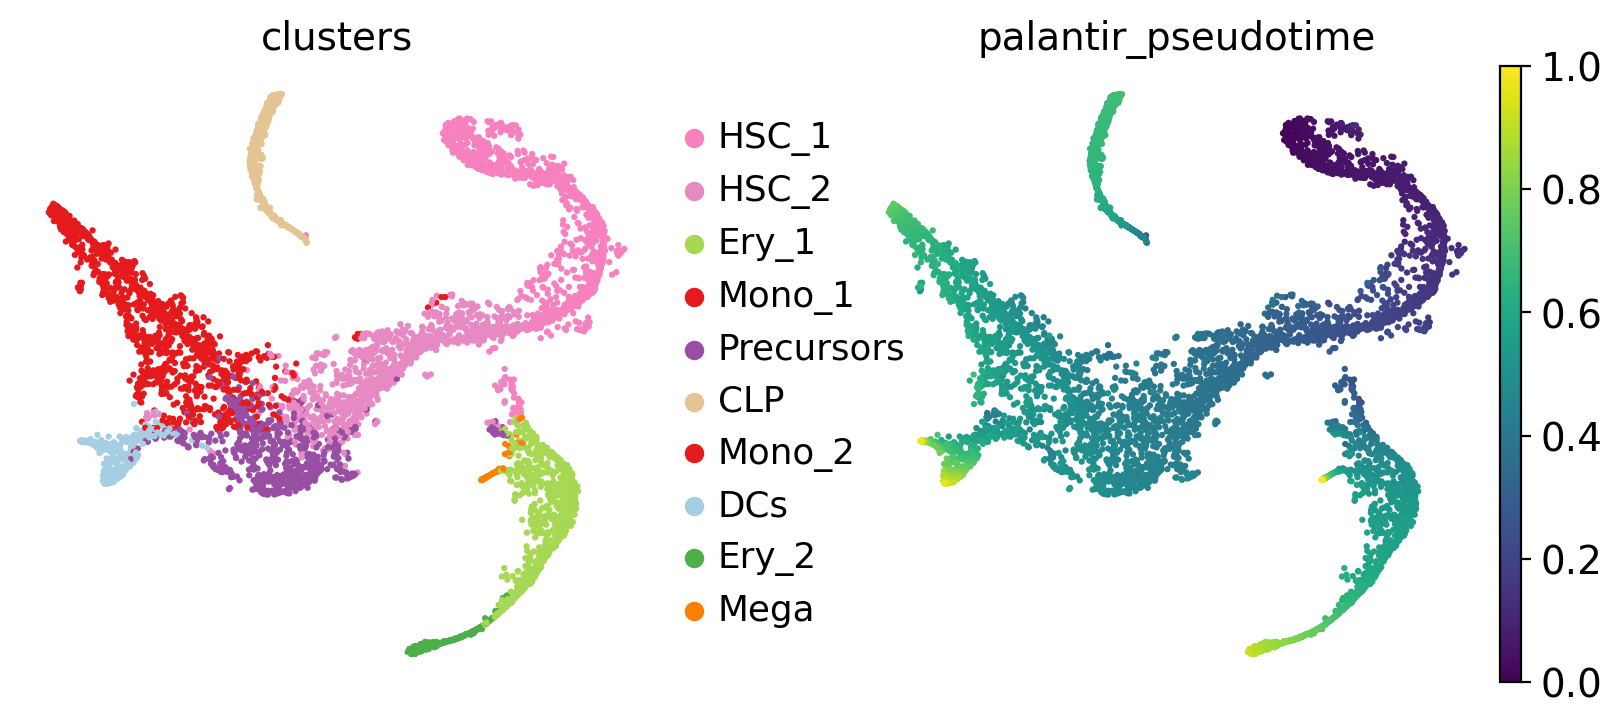

In [8]:
sc.pl.embedding(adata, basis="tsne", color=["clusters", "palantir_pseudotime"])

## Working with kernels

### Set up a kernel

To construct a transition matrix, CellRank offers a number of kernel classes in {mod}`~cellrank.kernels`. To demonstrate the concept, we'll use the {class}`~cellrank.kernels.PseudotimeKernel` which biases k-NN graph edges to point into the direction of increasing pseudotime, inspired by [Palantir](https://github.com/dpeerlab/Palantir) {cite}`setty:19`. 

For a full list of kernels, check out our {mod}`API <cellrank.kernels>`. To initialize a kernel object, simply run the following:

In [9]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="palantir_pseudotime")

Note that kernels need an {class}`anndata.AnnData` object to read data from it - CellRank is part of the [Scanpy/AnnData ecosystem](https://scanpy.readthedocs.io/en/latest/). The only exception to this is the {class}`cellrank.kernels.PrecomputedKernel` which directly accepts a transition matrix, thus making it possible to interface to CellRank from outside the scanpy/AnnData world. 

To learn more about our kernel object, we can print it. 

In [10]:
pk

PseudotimeKernel[n=5780]

There isn't very much here yet! Let's use this kernel to compute a cell-cell {mod}`~cellrank.kernels.PseudotimeKernel.transition_matrix`. 

In [11]:
pk.compute_transition_matrix()

Computing transition matrix based on pseudotime


  0%|          | 0/5780 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    Finish (0:00:02)


PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

If we print the kernel again, we can inspect the parameters that were used to compute this transition matrix. 

In [12]:
pk

PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

To get a first impression of the cellular dynamics in this dataset, we can simulate {meth}`random walks <cellrank.kernels.PseudotimeKernel.plot_random_walks>` on the [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) implied by the transition matrix, starting from hematopoietic stem cells (HSCs), and visualize these in the t-SNE embedding. 

Simulating `100` random walks of maximum length `1445`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:20)
Plotting random walks


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


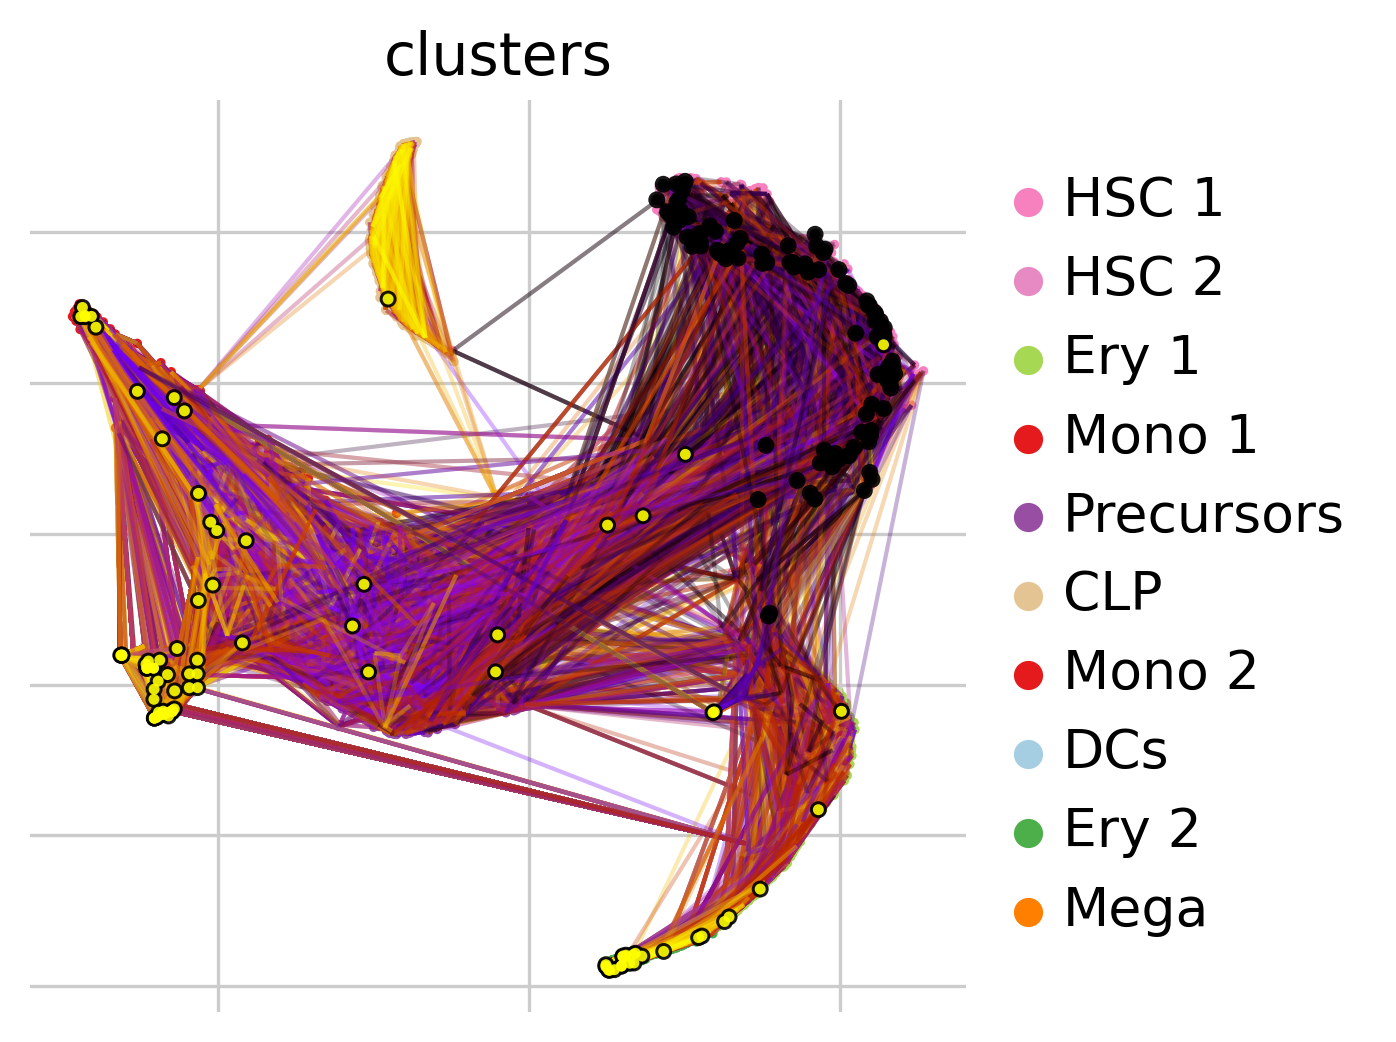

In [13]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"clusters": "HSC_1"},
    basis="tsne",
    legend_loc="right",
    dpi=150,
)

Black and yellow dots indicate random walk start and terminal cells, respectively. Overall, this reflects the known differentiation hierachy in human hematopoiesis. 

:::{seealso}

To learn more about the {class}`~cellrank.kernels.PseudotimeKernel`, see {doc}`../kernels/300_pseudotime`. 

:::

### Kernel overview

There exist CellRank kernels for many different data modalities. Each modality and biological system comes with its own strenghts and limitations, so it's important to choose the kernel carefully. We provide some guidance in the figure below. However, please check the {mod}`kernel API <cellrank.kernels>` for a complete and up-to-date list, as new kernels will come. 

:::{figure-md} fig-kernels

<img src="../_static/img/100_cellrank_kernels.jpg" alt="CellRank kernels are applicable to many different data modalities. " width="800px">

**A guide to kernel choice:** CellRank kernels support different data modalities and biological systems. Each comes with its own assumptions and limitations. 
:::

If you already have a cell-cell transition matrix for your data, you can pass that directly using the {class}`cellrank.kernels.PrecomputedKernel`, CellRank's interface with external methods. 

### Combining different kernels

Any two kernels can be globally combined via a weighted mean. To demonstrate this, let's set up an additional {class}`cellrank.kernels.ConnectivityKernel`, based on gene expression similarity. 

In [14]:
from cellrank.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Print the kernel to see some properties

In [15]:
ck

ConnectivityKernel[n=5780, dnorm=True, key='connectivities']

Combine with the {class}`~cellrank.kernels.PseudotimeKernel` PseudotimeKernel from above. 

In [16]:
combined_kernel = 0.8 * pk + 0.2 * ck
combined_kernel

(0.8 * PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * ConnectivityKernel[n=5780, dnorm=True, key='connectivities'])

This works for any combination of kernels, and generalizes to more than two kernels. Kernel combinations allow you to use distinct sources of information to describe cellular dynamics. 

### Writing and reading a kernel

Sometimes, we might want to write the kernel to disk, to either continue with the analysis later on, or to pass it to someone else. This can be easily done; simply write the kernel to adata, and write adata to file: 

In [17]:
pk.write_to_adata()
adata.write("hematopoiesis.h5ad")

To continue with the analysis, we read the {class}`anndata.AnnData` object from disk, and initialize a new kernel from the AnnData object. 

In [18]:
adata = sc.read("hematopoiesis.h5ad")
pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
pk_new

PseudotimeKernel[n=5780, dnorm=False, frac_to_keep=0.3, scheme='hard']

## Working with estimators

### Set up an estimator

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that represent the slow-time scale dynamics of the process. A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in {mod}`cellrank.estimators`:

 - {class}`~cellrank.estimators.CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - {class}`~cellrank.estimators.GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, {cite}`reuter:18, reuter:19`. 
 
We recommend the {class}`~cellrank.estimators.CFLARE` estimator; let's start by initializing it. 

In [19]:
from cellrank.estimators import GPCCA

g = GPCCA(pk_new)
print(g)

GPCCA[kernel=PseudotimeKernel[n=5780], initial_states=None, terminal_states=None]


### Identify initial & terminal states

Fit the estimator to compute macrostates of cellular dynamics; these may include {attr}`initial <cellrank.estimators.GPCCA.initial_states>`, {attr}`terminal <cellrank.estimators.GPCCA.terminal_states>` and intermediate states. 

In [20]:
g.fit(n_states=10, cluster_key="clusters")
g.plot_macrostates(which="all")

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `10` macrostates


AttributeError: can't set attribute 'categories'

For each macrostate, the algorithm computes an associated stability value. Let's use the most stable macrostates as {attr}`terminal <cellrank.estimators.GPCCA.terminal_states>` states {cite}`reuter:18, reuter:19, lange:22`. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


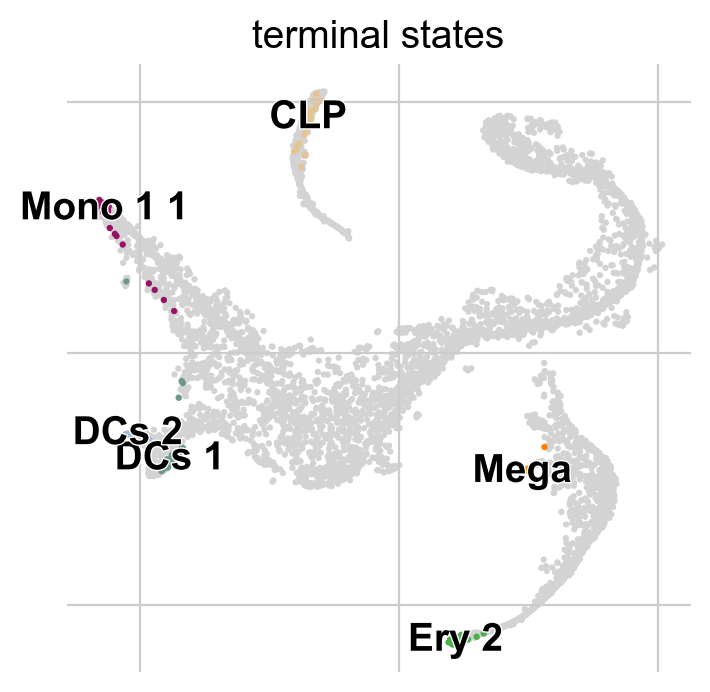

In [21]:
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal")

This correctly identified all major {attr}`terminal states <cellrank.estimators.GPCCA.terminal_states>` in this dataset. CellRank can also identify {attr}`initial states <cellrank.estimators.GPCCA.initial_states>` - in this dataset, that does not make too much sense though, as the initial state was manually passed to Palantir to root the pseudotime computation. 

:::{seealso}

To learn more about {attr}`initial <cellrank.estimators.GPCCA.initial_states>` and {attr}`terminal <cellrank.estimators.GPCCA.terminal_states>` state identification, see {doc}`../estimators/600_initial_terminal`. 

:::

### Compute fate probabilities and driver genes

We can now compute how likely each cell is to reach each terminal state using {func}`~cellrank.estimators.GPCCA.compute_fate_probabilities`. 

Computing fate probabilities


  0%|          | 0/6 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


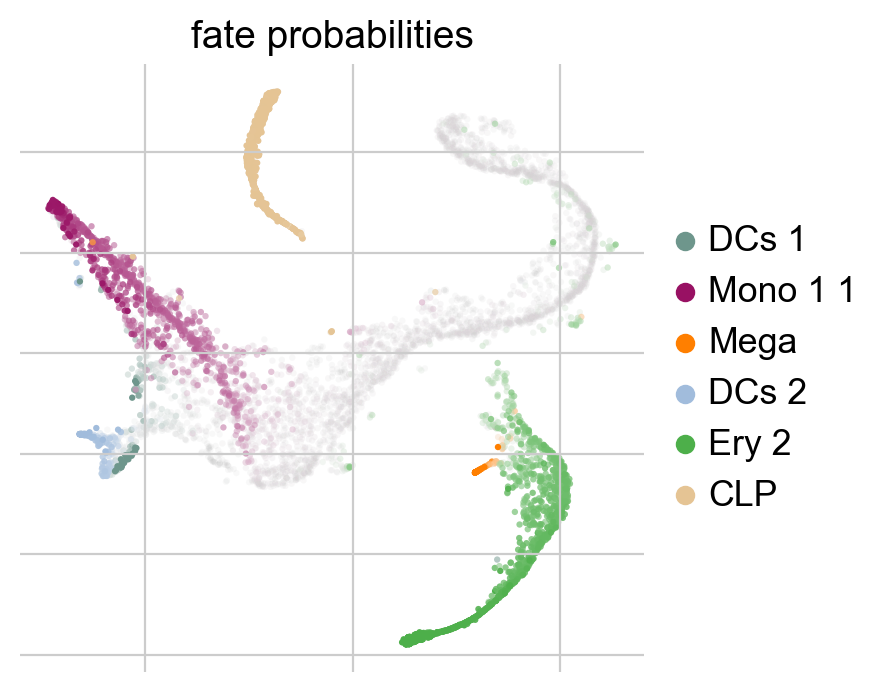

In [22]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(legend_loc="right")

The plot above combines fate probabilities towards all terminal states, each cell is colored according to its most likely fate; color intensity reflects the degree of lineage priming. We could equally plot fate probabilities separately for each terminal state, or we can visualize them jointly in a {func}`circular projection <cellrank.pl.circular_projection>` {cite}`velten:17, lange:22`. 

Solving TSP for `6` states


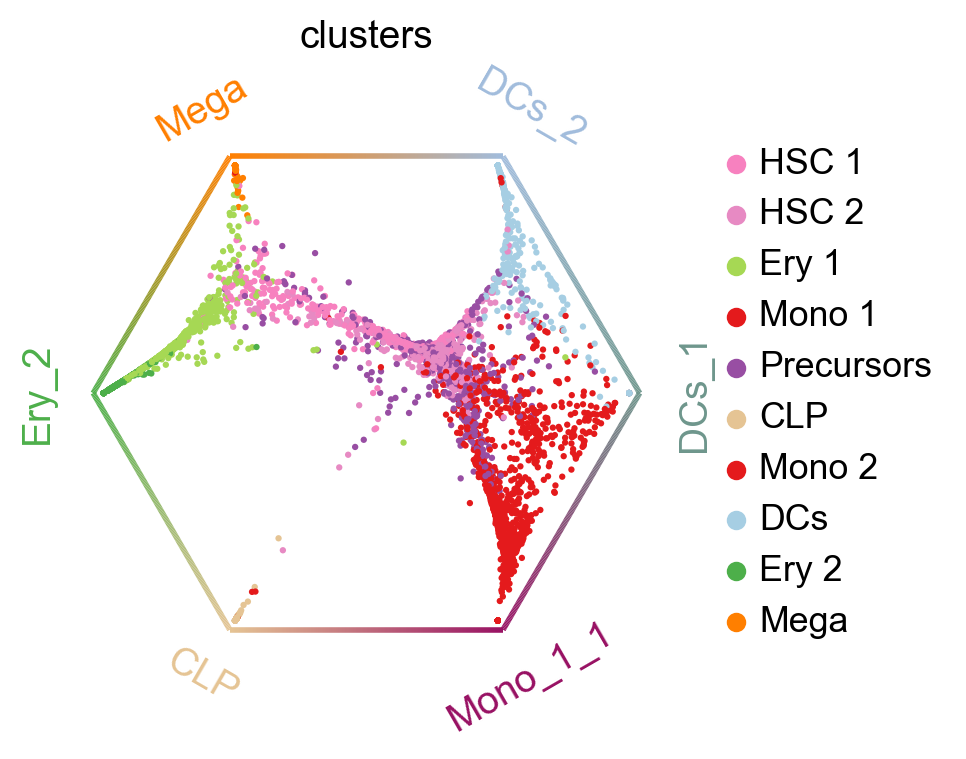

In [23]:
cr.pl.circular_projection(adata, keys="clusters", legend_loc="right")

Each dot represents a cell, colored by cluster labels. Cells are arranged inside the circle according to their fate probabilities; fate biased cells are placed next to their corresponding corner while naive cells are placed in the middle. 

To infer putative driver genes for any of these trajectories, we correlate expression values with fate probabilities. 

In [24]:
mono_drivers = g.compute_lineage_drivers(lineages="Mono_1_1")
mono_drivers.head(10)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


,Mono_1_1_corr,Mono_1_1_pval,Mono_1_1_qval,Mono_1_1_ci_low,Mono_1_1_ci_high
index,,,,,
AZU1,0.774242,0.0,0.0,0.763706,0.784367
MPO,0.741949,0.0,0.0,0.730134,0.753321
ELANE,0.736333,0.0,0.0,0.724302,0.747916
CTSG,0.722017,0.0,0.0,0.709442,0.734133
PRTN3,0.721471,0.0,0.0,0.708875,0.733606
CFD,0.614439,0.0,0.0,0.598133,0.630237
RNASE2,0.595055,0.0,0.0,0.578143,0.611456
MS4A3,0.581471,0.0,0.0,0.564147,0.598283
SRGN,0.570484,0.0,0.0,0.552833,0.587622


:::{seealso}

To learn more about fate probabilities and driver genes, see {doc}`../estimators/700_fate_probabilities`. 

:::

### Visualize expression trends

Given fate probabilities and a pseudotime, we can plot trajectory-specific gene expression trends. Specifically, we fit [Generalized Additive Models](https://en.wikipedia.org/wiki/Generalized_additive_model) (GAMs), weighthing each cells contribution to each trajectory according to its vector of fate probabilities. We start by initializing a {mod}`model <cellrank.models>`. 

In [25]:
model = cr.models.GAMR(adata)

:::{note}

The {class}`~cellrank.models.GAMR` uses the R package [mgcv](https://cran.r-project.org/web/packages/mgcv/index.html) for parameter fitting; this requires you to have [rpy2](https://rpy2.github.io/) installed. To avoid this and remain entirely in python, you can use {class}`cellrank.models.GAM`, which uses [pyGAM](https://pygam.readthedocs.io/en/latest/) for parameter fitting. 

:::

With the model initialized, we can visualize gene dynamics along specific trajectories. 

Computing trends using `1` core(s)


  0%|          | 0/4 [00:00<?, ?gene/s]

    Finish (0:00:00)
Plotting trends


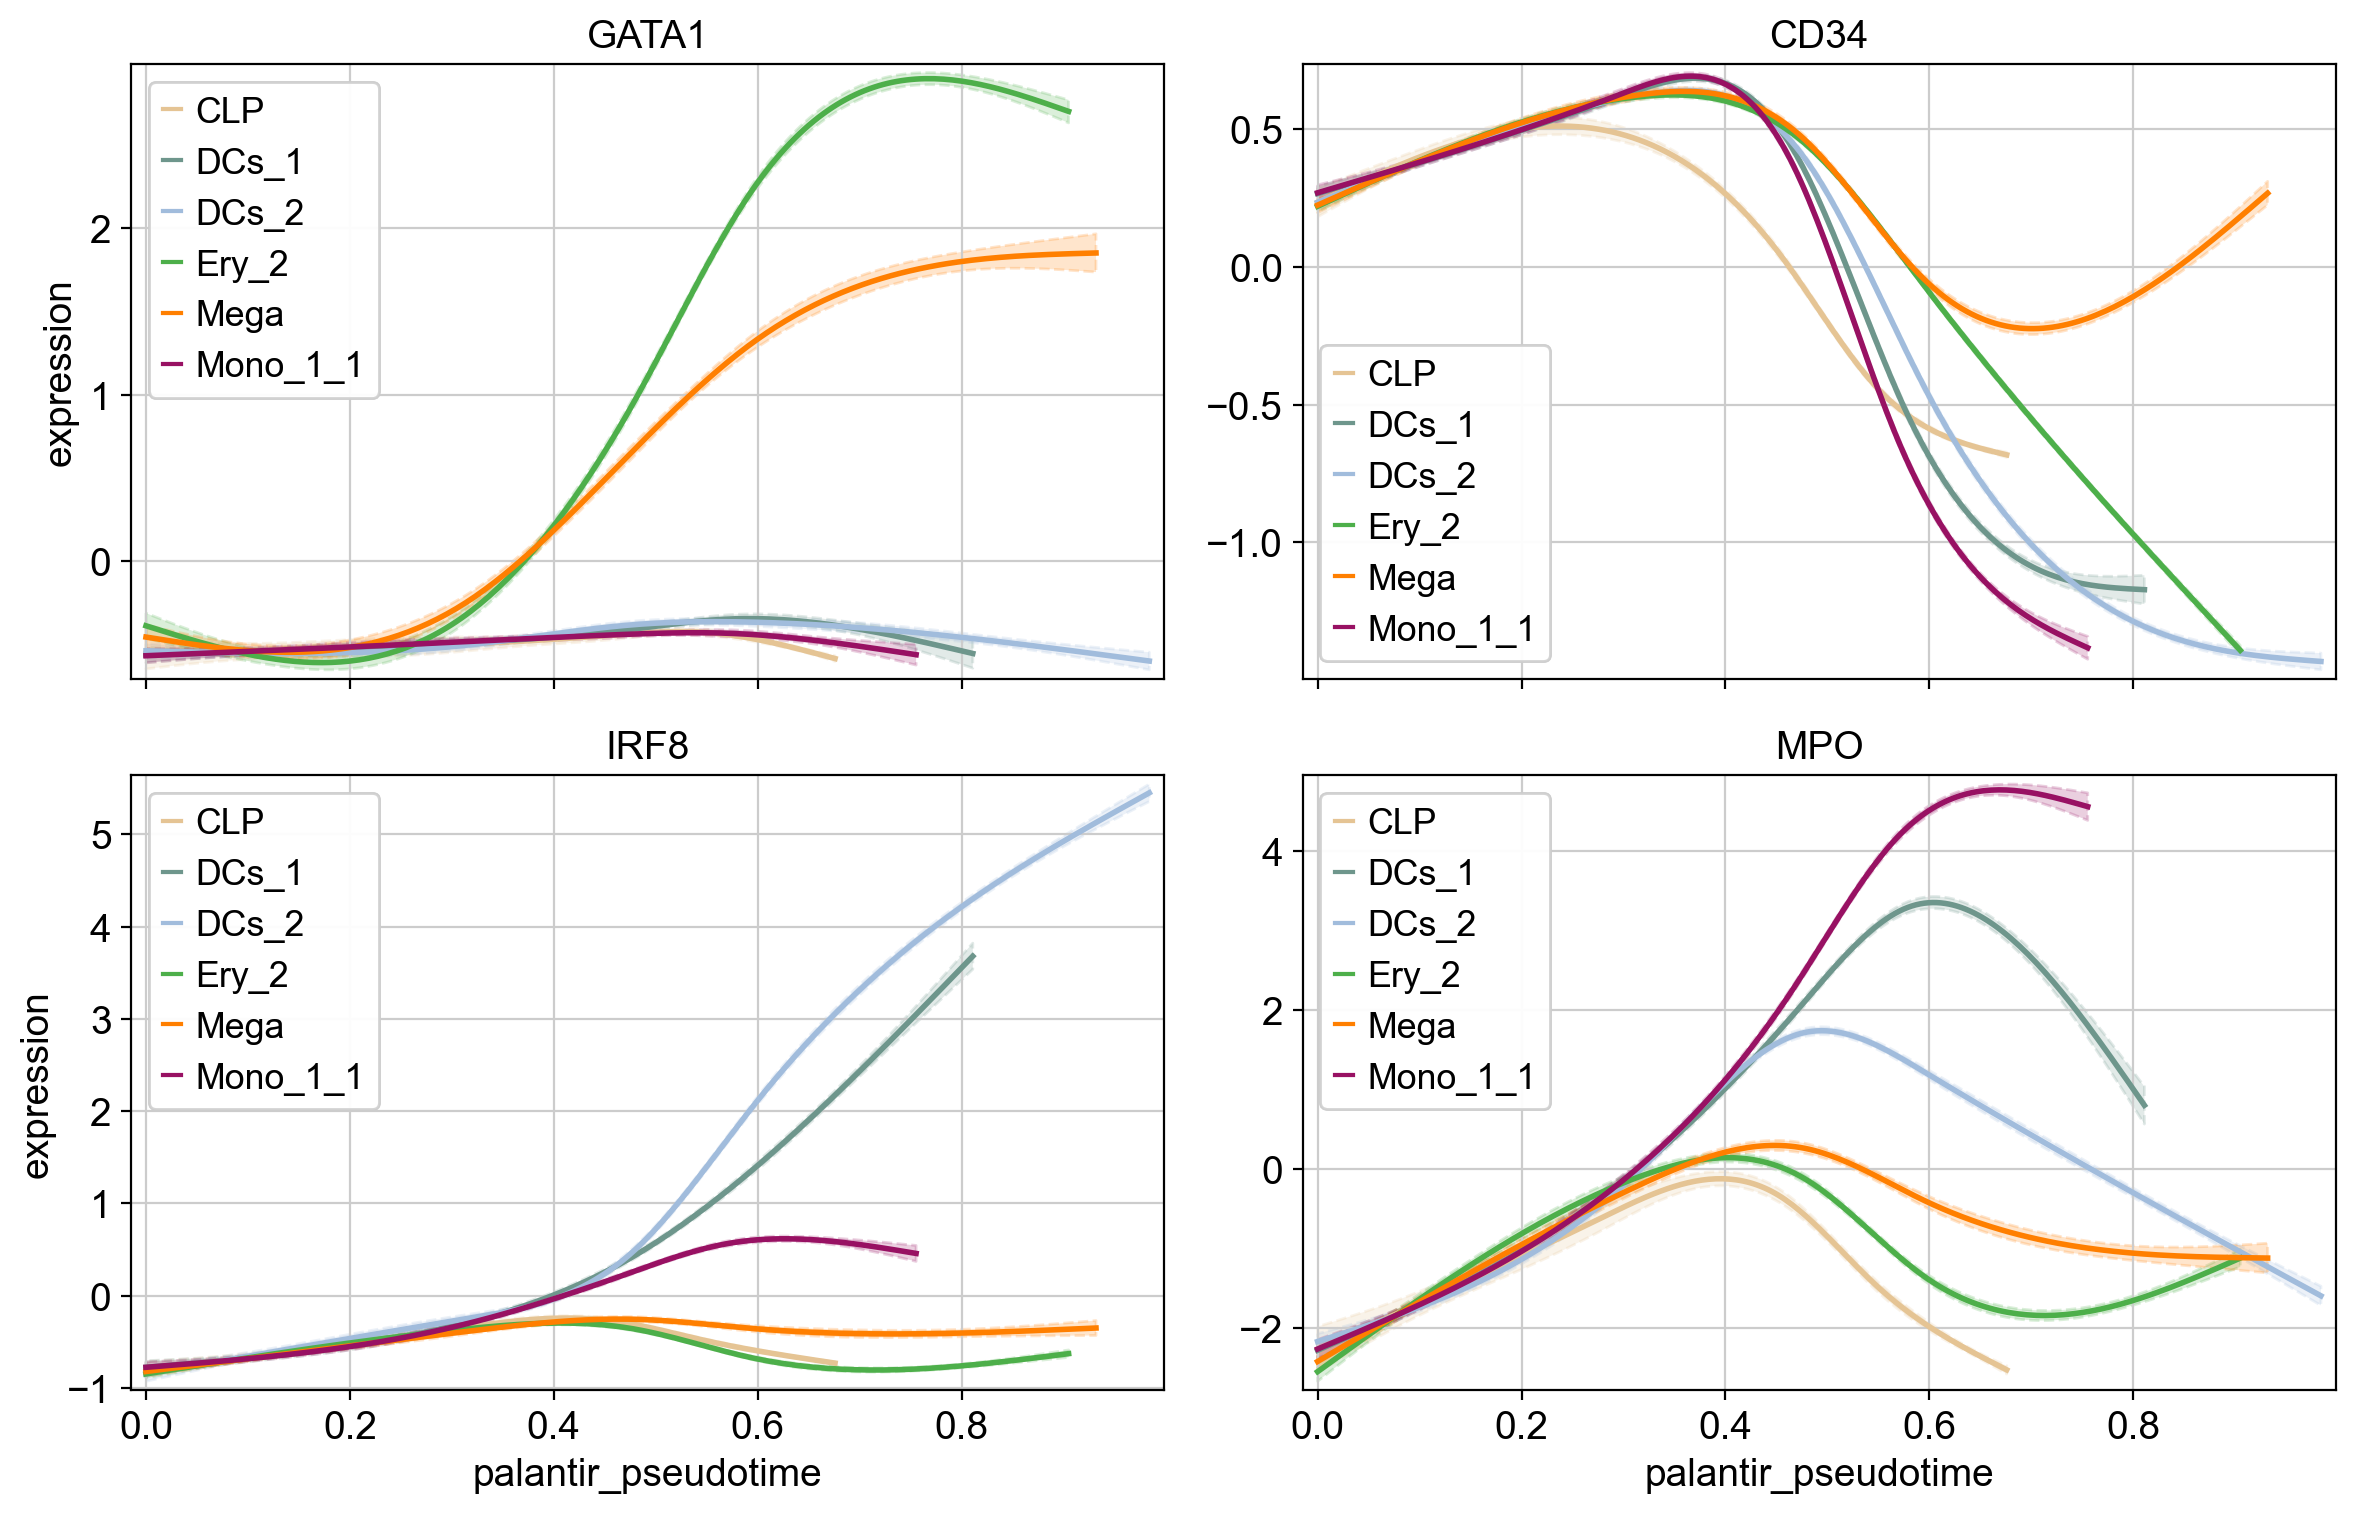

In [26]:
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    same_plot=True,
    ncols=2,
    time_key="palantir_pseudotime",
    hide_cells=True,
)

:::{note}

We use [MAGIC-imputed](https://github.com/KrishnaswamyLab/MAGIC) data for gene-trend visualization {cite}`vandijk:18`. We don't use imputed data for any other task. 

:::

Above, we grouped expression trends by gene, and visualized several trajectories per panel. We can also do it the other way round - group expression trends by trajectory, visualize several genes per panel. While this is possible using the line plots from above (set `transpose=True`), we'll demonstrate it using heatmaps. 

Computing trends using `1` core(s)


  0%|          | 0/4 [00:00<?, ?gene/s]

    Finish (0:00:00)


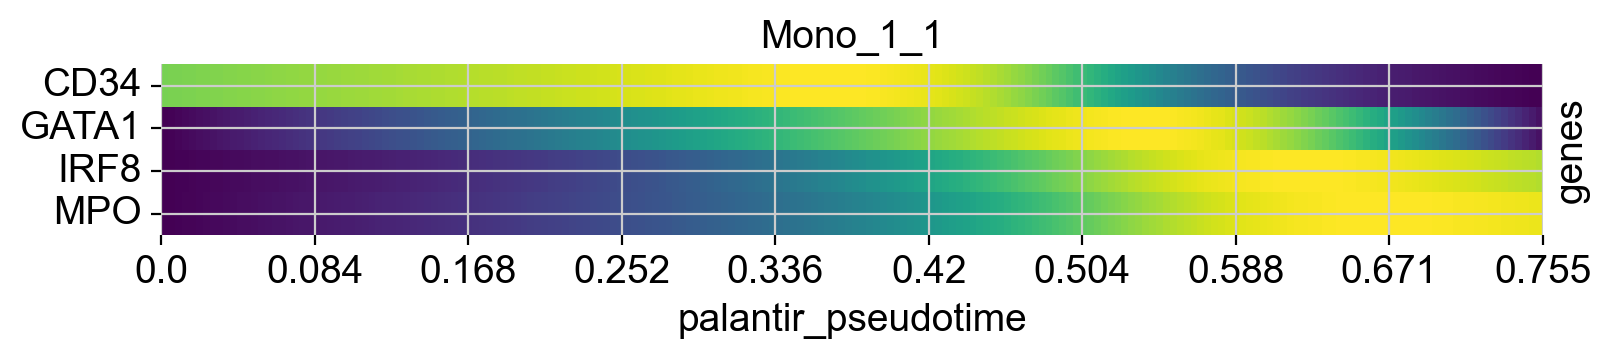

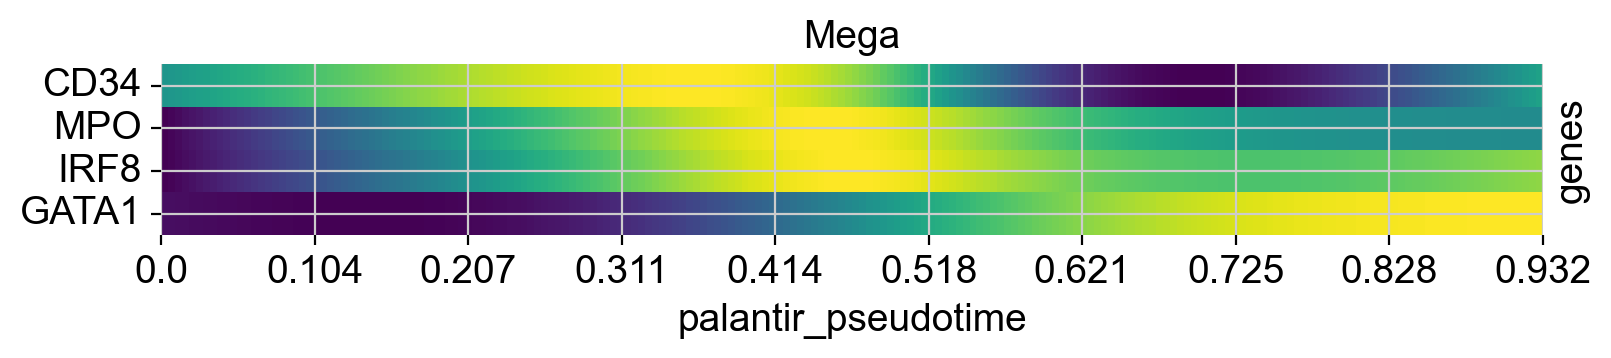

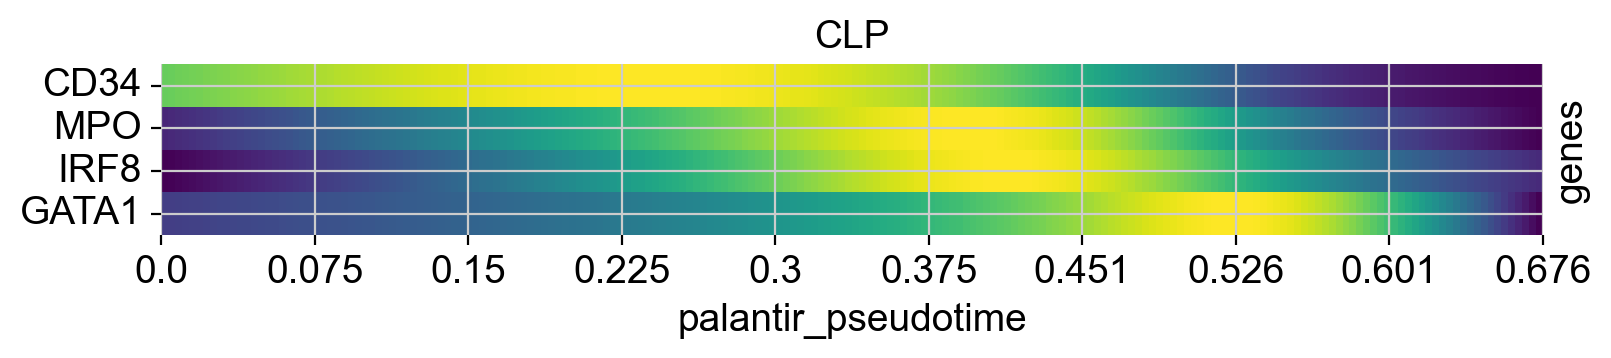

In [27]:
cr.pl.heatmap(
    adata,
    model=model,
    data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    lineages=["Mono_1_1", "Mega", "CLP"],
    time_key="palantir_pseudotime",
    cbar=False,
    show_all_genes=True,
)

:::{seealso}

To learn more about gene trend visualization and clustering, see {doc}`../estimators/800_gene_trends`. 

:::

## Closing matters

### Creating a new kernel - contributing to CellRank

If you have you own method in mind for computing a cell-cell transition matrix, potentially based on some new data modality, consider including it as a kernel in CellRank. That way, you benefit from CellRank's established interfaces with packages like {mod}`~scanpy` or {class}`~anndata.AnnData`, can take advantage of existing downstream analysis capabilities, and immediately reach a large audience of existing CellRank users. 

:::{seealso}

To learn more about creating your own kernel, see TODO. 

:::

### What's next? 

In this tutorial, you learned the basics of CellRank. For the next steps, we recommend to:

- explore the various CellRank kernels (REF) and corresponding tutorials. 
- take a look at the {doc}`API <cellrank.kernels.PseudotimeKernel>` to learn about parameter values you can use to adapt these computations to your data. 
- dive deeper into {doc}`initial and terminal states <../estimators/600_initial_terminal>`, {doc}`fate probabilities <../estimators/700_fate_probabilities>`, and {doc}`gene expression trends <../estimators/800_gene_trends>`. 

### Package versions

In [21]:
cr.logging.print_versions()

cellrank==1.5.2.dev236+gab039002 scanpy==1.9.3 anndata==0.9.1 numpy==1.24.2 numba==0.57.1 scipy==1.11.0 pandas==2.0.2 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.14.0 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.1 seaborn==0.12.2


In [28]:
cr.logging.print_versions()

cellrank==1.5.2.dev206+ga2748bea scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
